# librerias

In [116]:
!pip install imblearn


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [117]:
from __future__ import absolute_import,division,print_function,unicode_literals
import pandas as pd
import tensorflow as tf
from tensorflow.keras import datasets, layers,models
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm
import cv2
from glob import glob
import sklearn
import skimage
from skimage.transform import resize
import random
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from skimage.color import rgb2gray
import datetime

# importamos el dataset

In [118]:
train_dir="chest_xray/train/"
test_dir="chest_xray/test/"
val_dir="chest_xray/val/"

In [119]:
LOAD_FROM_IMAGES = True

# Función para obtener imágenes
def get_data(folder):
    x = []
    y = []
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ["NORMAL"]:
                label = 0
            elif folderName in ["PNEUMONIA"]:
                label = 1
            else:
                label = 2
            for image_filename in tqdm(os.listdir(folder + folderName)):
                img_file = cv2.imread(folder + folderName + "/" + image_filename)
                if img_file is not None:
                    img_file = skimage.transform.resize(img_file, (150, 150, 3), mode="constant", anti_aliasing=True)
                    # Convierto a blanco y negro
                    img_file = rgb2gray(img_file)
                    img_arr = np.array(img_file)
                    x.append(img_arr)
                    y.append(label)
    x = np.asarray(x)
    y = np.asarray(y)
    return x, y

if LOAD_FROM_IMAGES:
    # Obtenemos las imágenes en arrays para entrenar
    x_train, y_train = get_data(train_dir)
    x_test, y_test = get_data(test_dir)
    x_val, y_val = get_data(val_dir)

    # Guardamos los arrays en archivos
    np.save("xtrain.npy", x_train)
    np.save("ytrain.npy", y_train)
    np.save("xtest.npy", x_test)
    np.save("ytest.npy", y_test)
    np.save("xval.npy", x_val)
    np.save("yval.npy", y_val)
else:
    # Cargamos los arrays
    x_train = np.load("xtrain.npy")
    y_train = np.load("ytrain.npy")
    x_test = np.load("xtest.npy")
    y_test = np.load("ytest.npy")
    x_val = np.load("xval.npy")
    y_val = np.load("yval.npy")

100%|██████████| 9/9 [00:01<00:00,  7.30it/s]


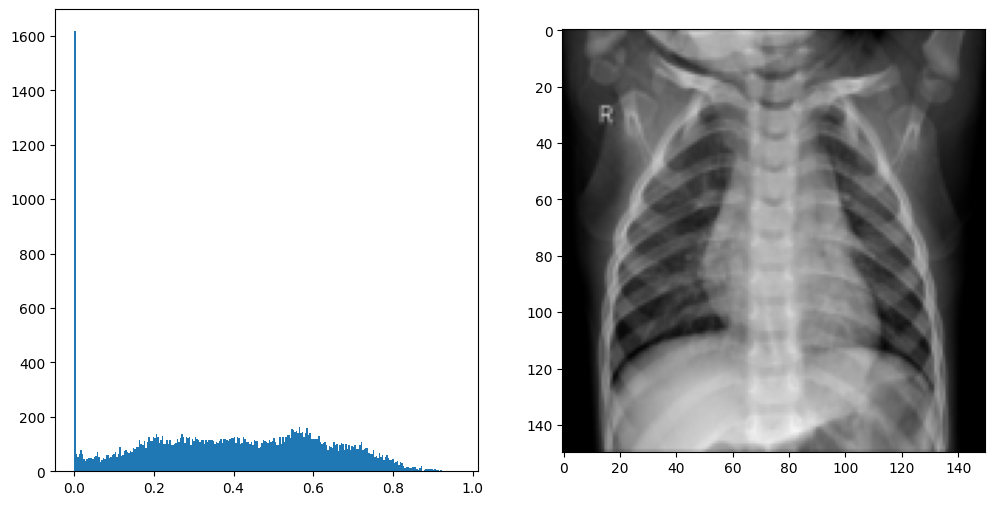

In [120]:
#mostrar un histograma de una radiografia
def plotHistogram(a):
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.hist(a.ravel(),bins=255)
    plt.subplot(1,2,2)
    plt.imshow(a,cmap="gray",vmin=0,vmax=1)
    plt.show()
plotHistogram(x_train[1])
    

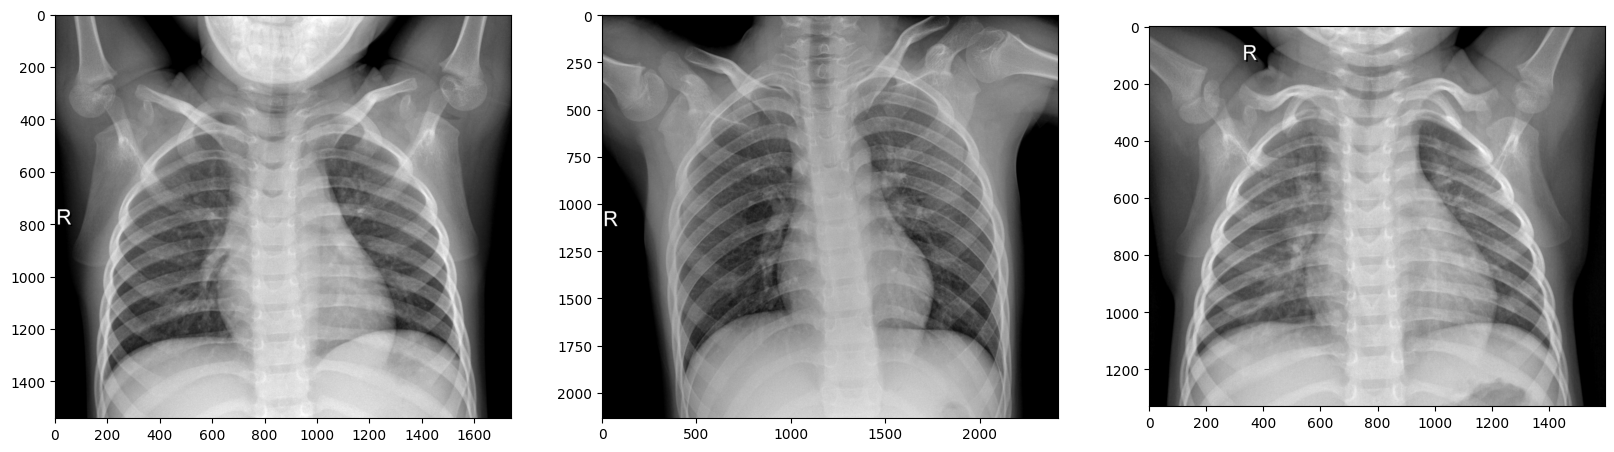

In [121]:
#pacientes normales
normales=glob("chest_xray/train/NORMAL/**")
def plotThreeNormalImages(images):
    r=random.sample(images,3)
    plt.figure(figsize=(20,20))
    plt.subplot(1,3,1)
    plt.imshow(cv2.imread(r[0]))
    plt.subplot(1,3,2)
    plt.imshow(cv2.imread(r[1]))
    plt.subplot(1,3,3)
    plt.imshow(cv2.imread(r[2]))
plotThreeNormalImages(normales)

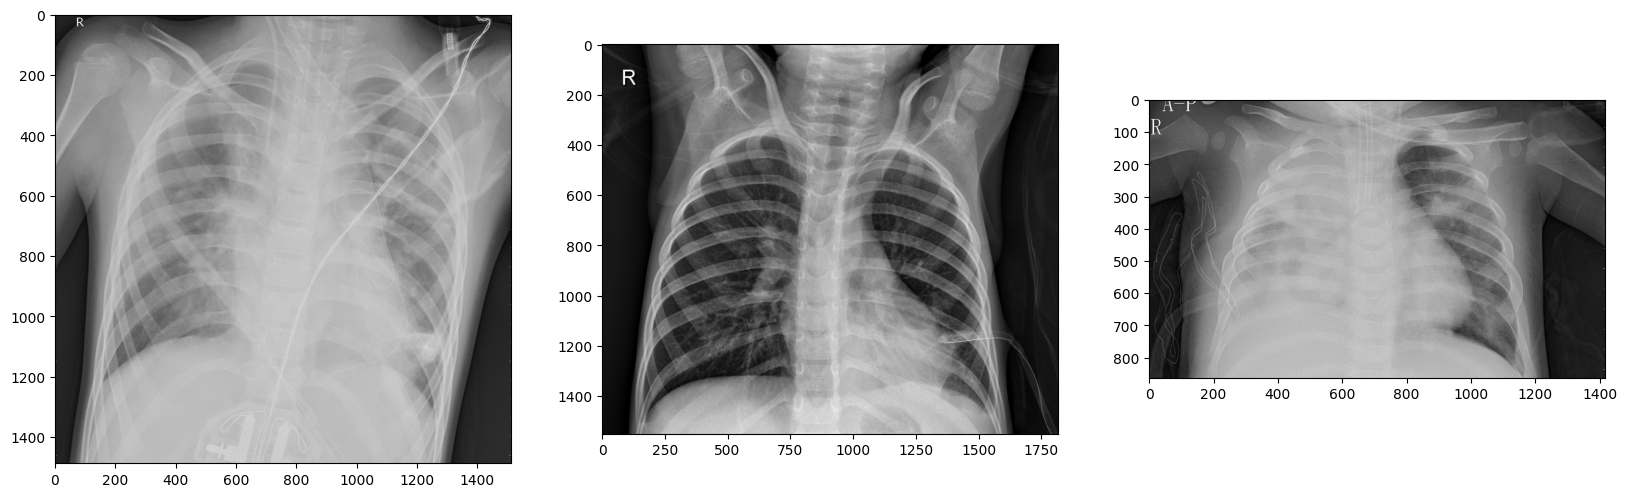

In [122]:
#pacientes con neumonia
afectados=glob("chest_xray/train/PNEUMONIA/**")
def plotThreeProblemImages(images):
    r=random.sample(images,3)
    plt.figure(figsize=(20,20))
    plt.subplot(1,3,1)
    plt.imshow(cv2.imread(r[0]))
    plt.subplot(1,3,2)
    plt.imshow(cv2.imread(r[1]))
    plt.subplot(1,3,3)
    plt.imshow(cv2.imread(r[2]))
plotThreeProblemImages(afectados)

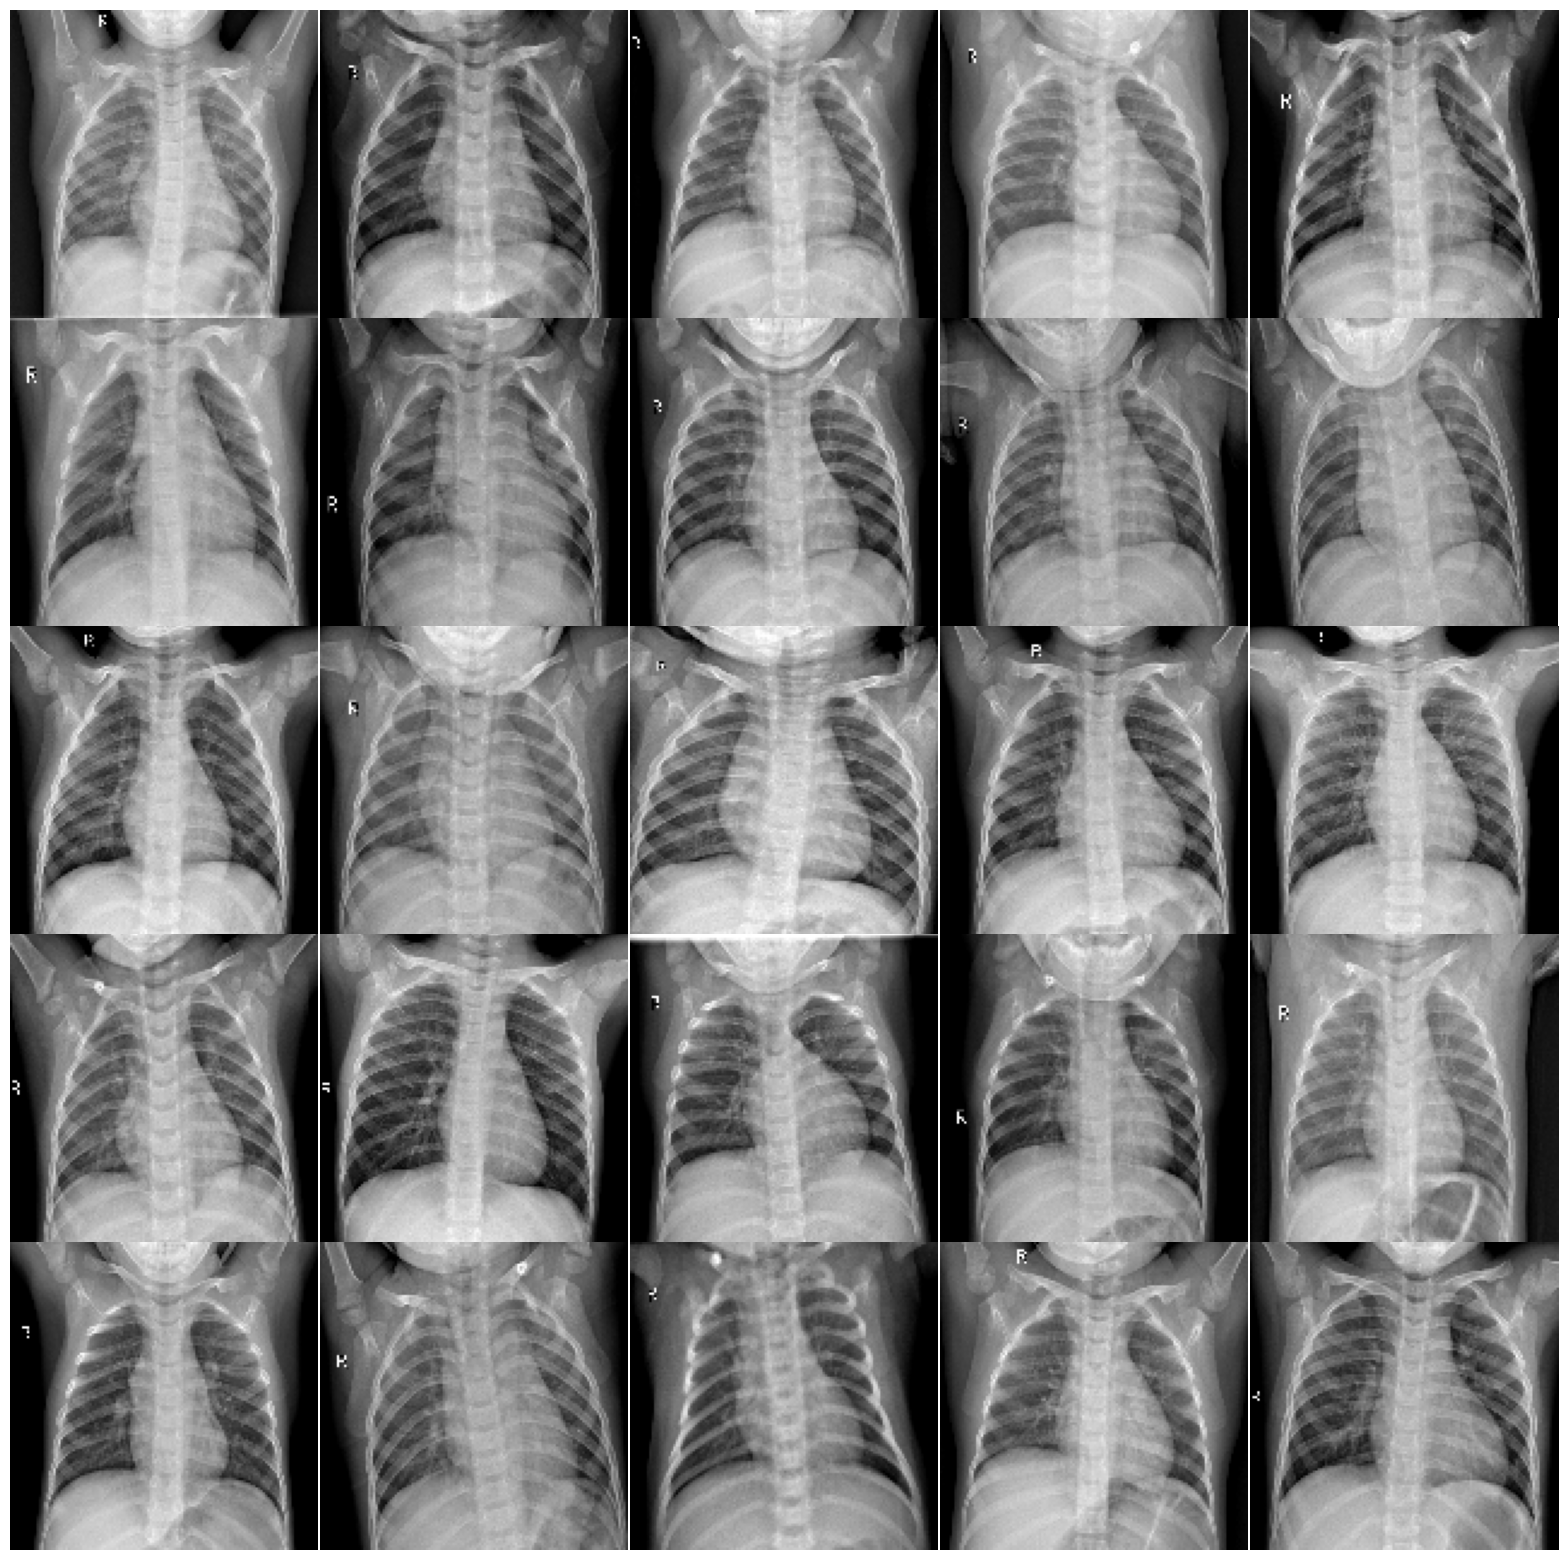

In [123]:
#imprimimos muchas normales
normales=glob("chest_xray/train/NORMAL/**")

plt.rcParams["figure.figsize"]=(20.0,20.0)
plt.subplots_adjust(wspace=0,hspace=0)
def plotSomeNormalImages(images):
    i_=0
    for i in images[:25]:
        foto=cv2.imread(i)
        foto=cv2.resize(foto,(128,128))
        plt.subplot(5,5,i_+1)
        plt.imshow(cv2.cvtColor(foto,cv2.COLOR_BGR2RGB));plt.axis("off")
        i_+=1
plotSomeNormalImages(normales)

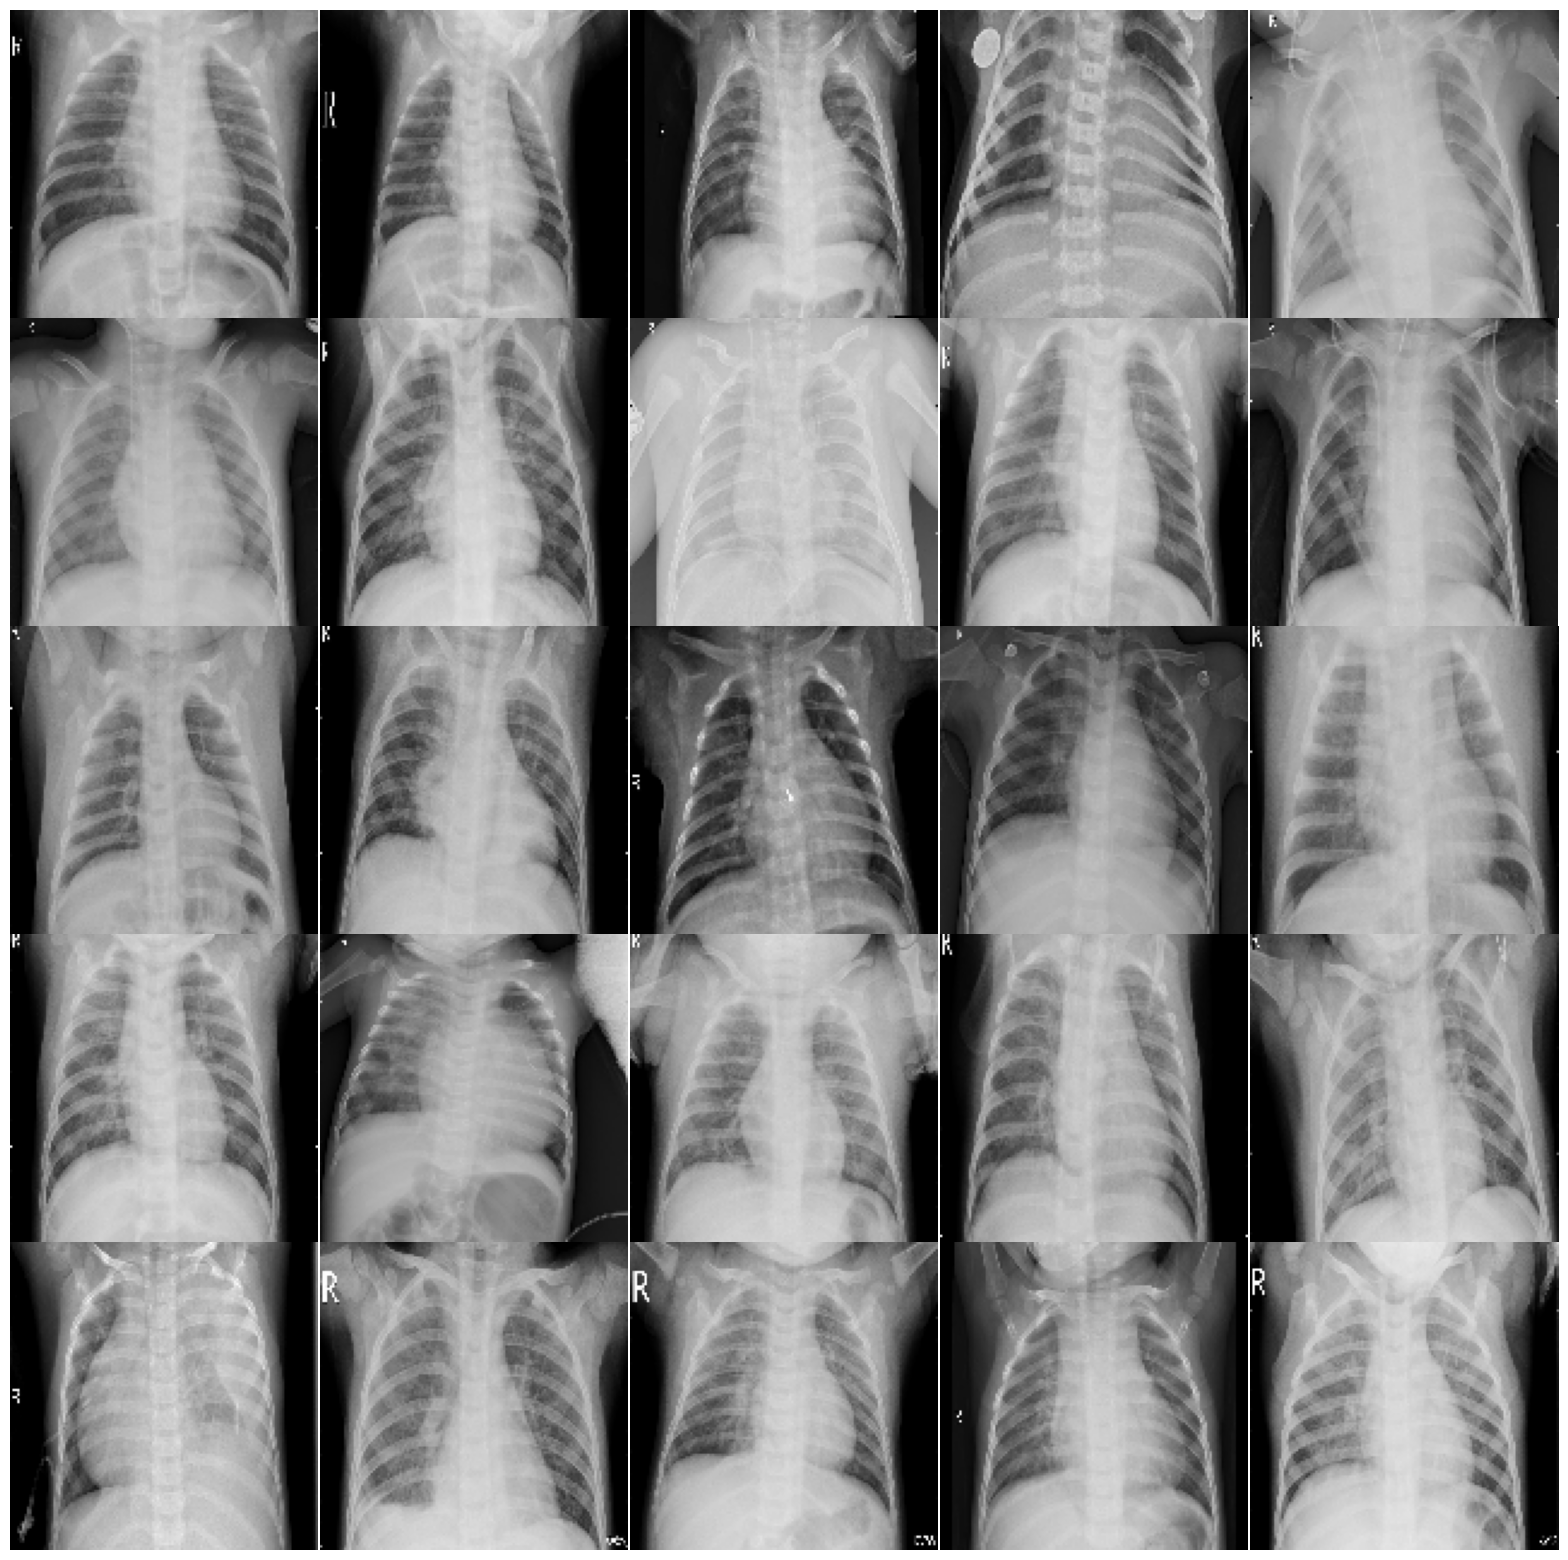

In [124]:
#imprimimos muchas afectados
normales=glob("chest_xray/train/PNEUMONIA//**")

plt.rcParams["figure.figsize"]=(20.0,20.0)
plt.subplots_adjust(wspace=0,hspace=0)
def plotSomeNormalImages(images):
    i_=0
    for i in images[:25]:
        foto=cv2.imread(i)
        foto=cv2.resize(foto,(128,128))
        plt.subplot(5,5,i_+1)
        plt.imshow(cv2.cvtColor(foto,cv2.COLOR_BGR2RGB));plt.axis("off")
        i_+=1
plotSomeNormalImages(normales)

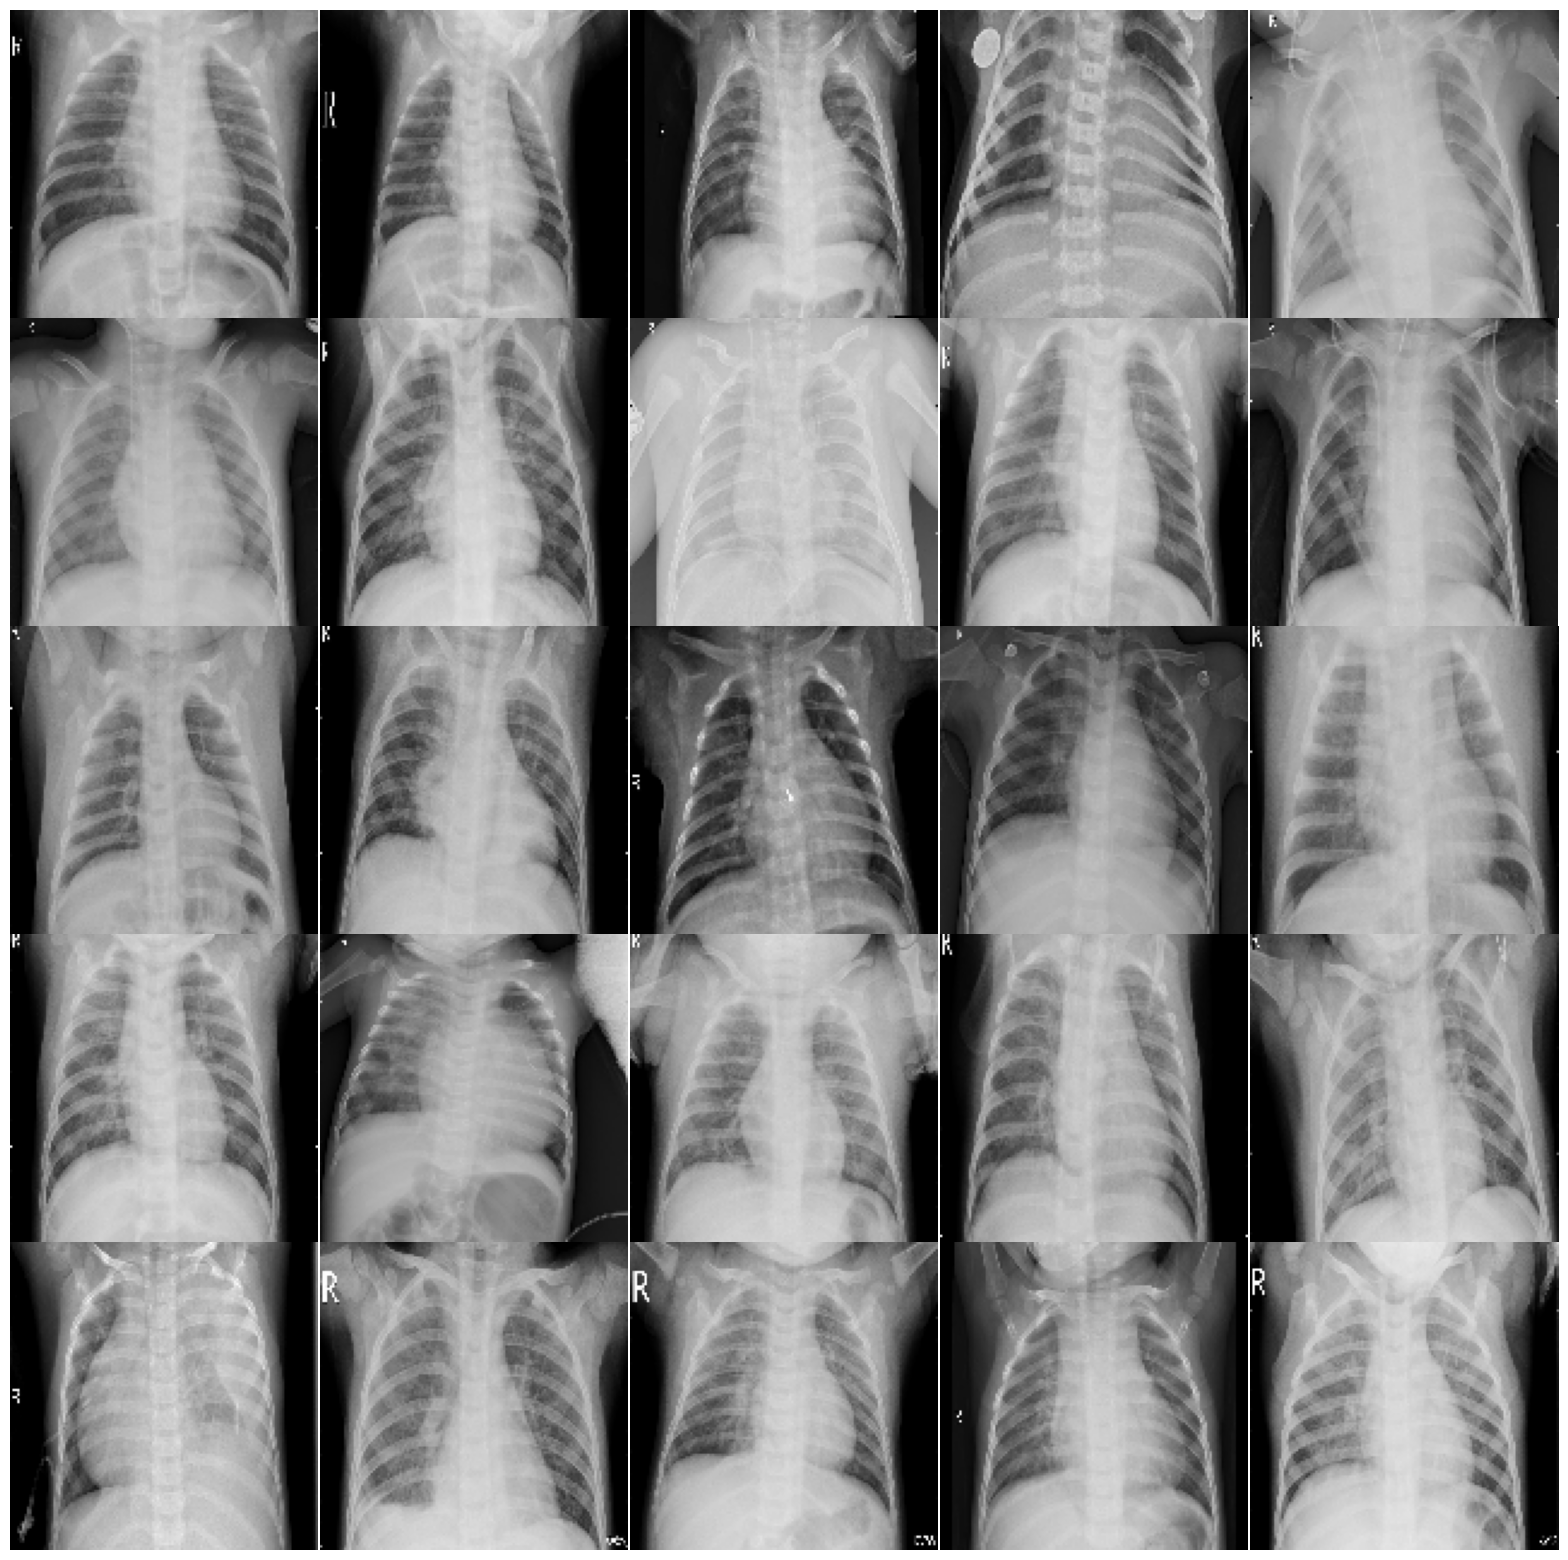

In [125]:

#imprimimos muchas
afectados=glob("chest_xray/train/PNEUMONIA/**")
plt.rcParams["figure.figsize"]=(20.0,20.0)
plt.subplots_adjust(wspace=0,hspace=0)
def plotSomeProblemImages(images):
    i_=0
    for i in images[:25]:
        foto=cv2.imread(i)
        foto=cv2.resize(foto,(128,128))
        plt.subplot(5,5,i_+1)
        plt.imshow(cv2.cvtColor(foto,cv2.COLOR_BGR2RGB));plt.axis("off")
        i_+=1
plotSomeProblemImages(afectados)

#### UTILIZAMOS SEABORN PARA CONFIRMAR BALANCEO

{0: 'NORMALES', 1: 'NEUMONIA'}


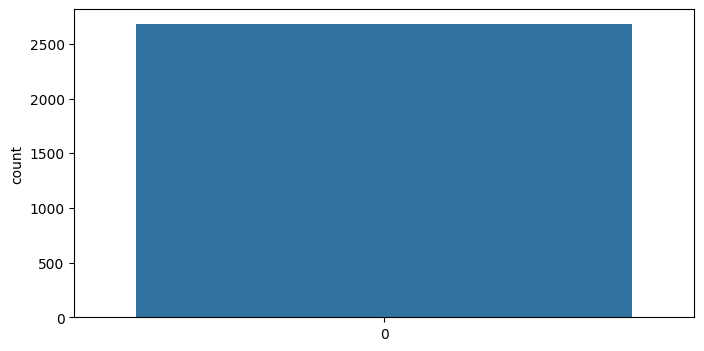

In [126]:
import seaborn as sns
plt.figure(figsize=(8,4))
map_characters={0:"NORMALES",1:"NEUMONIA"}
dict_characters=map_characters
df=pd.DataFrame()
df["labels"]=y_train
lab=df["labels"]
dist=lab.value_counts()
sns.countplot(lab)
print(dict_characters)

In [127]:
x_train.shape
# (cantidad_imagenes,ancho,alto)

(2682, 150, 150)

### tenemos que darle una dimension de color

In [128]:
# (cantidad_imagenes,ancho,alto,color)
x_train_reshaped=x_train.reshape(len(x_train),150,150,1)
x_test_reshaped=x_test.reshape(len(x_test),150,150,1)
x_val_reshaped=x_val.reshape(len(x_val),150,150,1)

In [129]:
x_train_reshaped.shape

(2682, 150, 150, 1)

In [130]:
x_test_reshaped.shape

(624, 150, 150, 1)

In [131]:
x_val_reshaped.shape

(16, 150, 150, 1)

### procedemos a realizar el modelo

In [132]:
modelo_guardado = 'reconocimiento_neumonia.h5'

# Verificar si el modelo ya existe
if os.path.exists(modelo_guardado):
    # Cargar el modelo existente
    model = models.load_model(modelo_guardado)
    print("Modelo cargado exitosamente.")
else:
    #declaramos el modelo
    model=models.Sequential()
    #agregamos una capa incovando redes neuronales convolucionales
    model.add(layers.Conv2D(64,(3,3),activation="relu",input_shape=(150,150,1)))
    model.add(layers.MaxPooling2D((2,2)))
    #capa 2 oculta
    model.add(layers.Conv2D(64,(3,3),activation="relu"))
    model.add(layers.MaxPooling2D((2,2)))
    #capa 3 oculta
    model.add(layers.Conv2D(64,(3,3),activation="relu"))
    model.add(layers.MaxPooling2D((2,2)))
    #capa con la que aplanamos los valores
    model.add(layers.Conv2D(64,(3,3),activation="relu"))

    model.add(layers.Flatten())
    model.add(layers.Dense(64,activation="relu"))

    #capa de salida
    model.add(layers.Dense(2,activation="softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 64)      640       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 17, 17, 64)      

### compilamos el modelo

In [133]:
# Verificar si el modelo ya existe
if os.path.exists(modelo_guardado)==False:
    model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])
    log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir,histogram_freq=1)
    model.fit(x_train_reshaped,
            y_train,
            epochs=10,
            validation_data=(x_val,y_val),
            callbacks=[tensorboard_callback])

Epoch 1/10
84/84 [==============================] - 103s 1s/step - loss: 0.5118 - accuracy: 0.7304 - val_loss: 0.6303 - val_accuracy: 0.7500
Epoch 2/10
84/84 [==============================] - 103s 1s/step - loss: 0.2070 - accuracy: 0.9243 - val_loss: 0.3234 - val_accuracy: 0.8750
Epoch 3/10
84/84 [==============================] - 108s 1s/step - loss: 0.1109 - accuracy: 0.9597 - val_loss: 0.2483 - val_accuracy: 0.9375
Epoch 4/10
84/84 [==============================] - 142s 2s/step - loss: 0.0860 - accuracy: 0.9668 - val_loss: 0.1828 - val_accuracy: 0.8750
Epoch 5/10
84/84 [==============================] - 130s 2s/step - loss: 0.0934 - accuracy: 0.9679 - val_loss: 0.2021 - val_accuracy: 0.8750
Epoch 6/10
84/84 [==============================] - 129s 2s/step - loss: 0.0610 - accuracy: 0.9773 - val_loss: 0.3909 - val_accuracy: 0.8125
Epoch 7/10
84/84 [==============================] - 130s 2s/step - loss: 0.0602 - accuracy: 0.9761 - val_loss: 0.5174 - val_accuracy: 0.6875
Epoch 8/10
84

In [134]:
if os.path.exists(modelo_guardado)==False:
    model.save('reconocimiento_neumonia.h5')

In [135]:
test_loss,test_acc=model.evaluate(x_test_reshaped,y_test)
print(test_acc)

20/20 [==============================] - 7s 310ms/step - loss: 1.0140 - accuracy: 0.8061
0.8060897588729858


In [136]:
train_loss,train_acc=model.evaluate(x_train_reshaped,y_train)

84/84 [==============================] - 27s 319ms/step - loss: 0.0173 - accuracy: 0.9937


In [137]:
print(train_acc)

0.9936614632606506


In [138]:
predictions=model.predict(x_test_reshaped)

20/20 [==============================] - 7s 331ms/step


In [139]:
predictions[0]

array([0.9968413 , 0.00315869], dtype=float32)

In [140]:
print(y_test)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

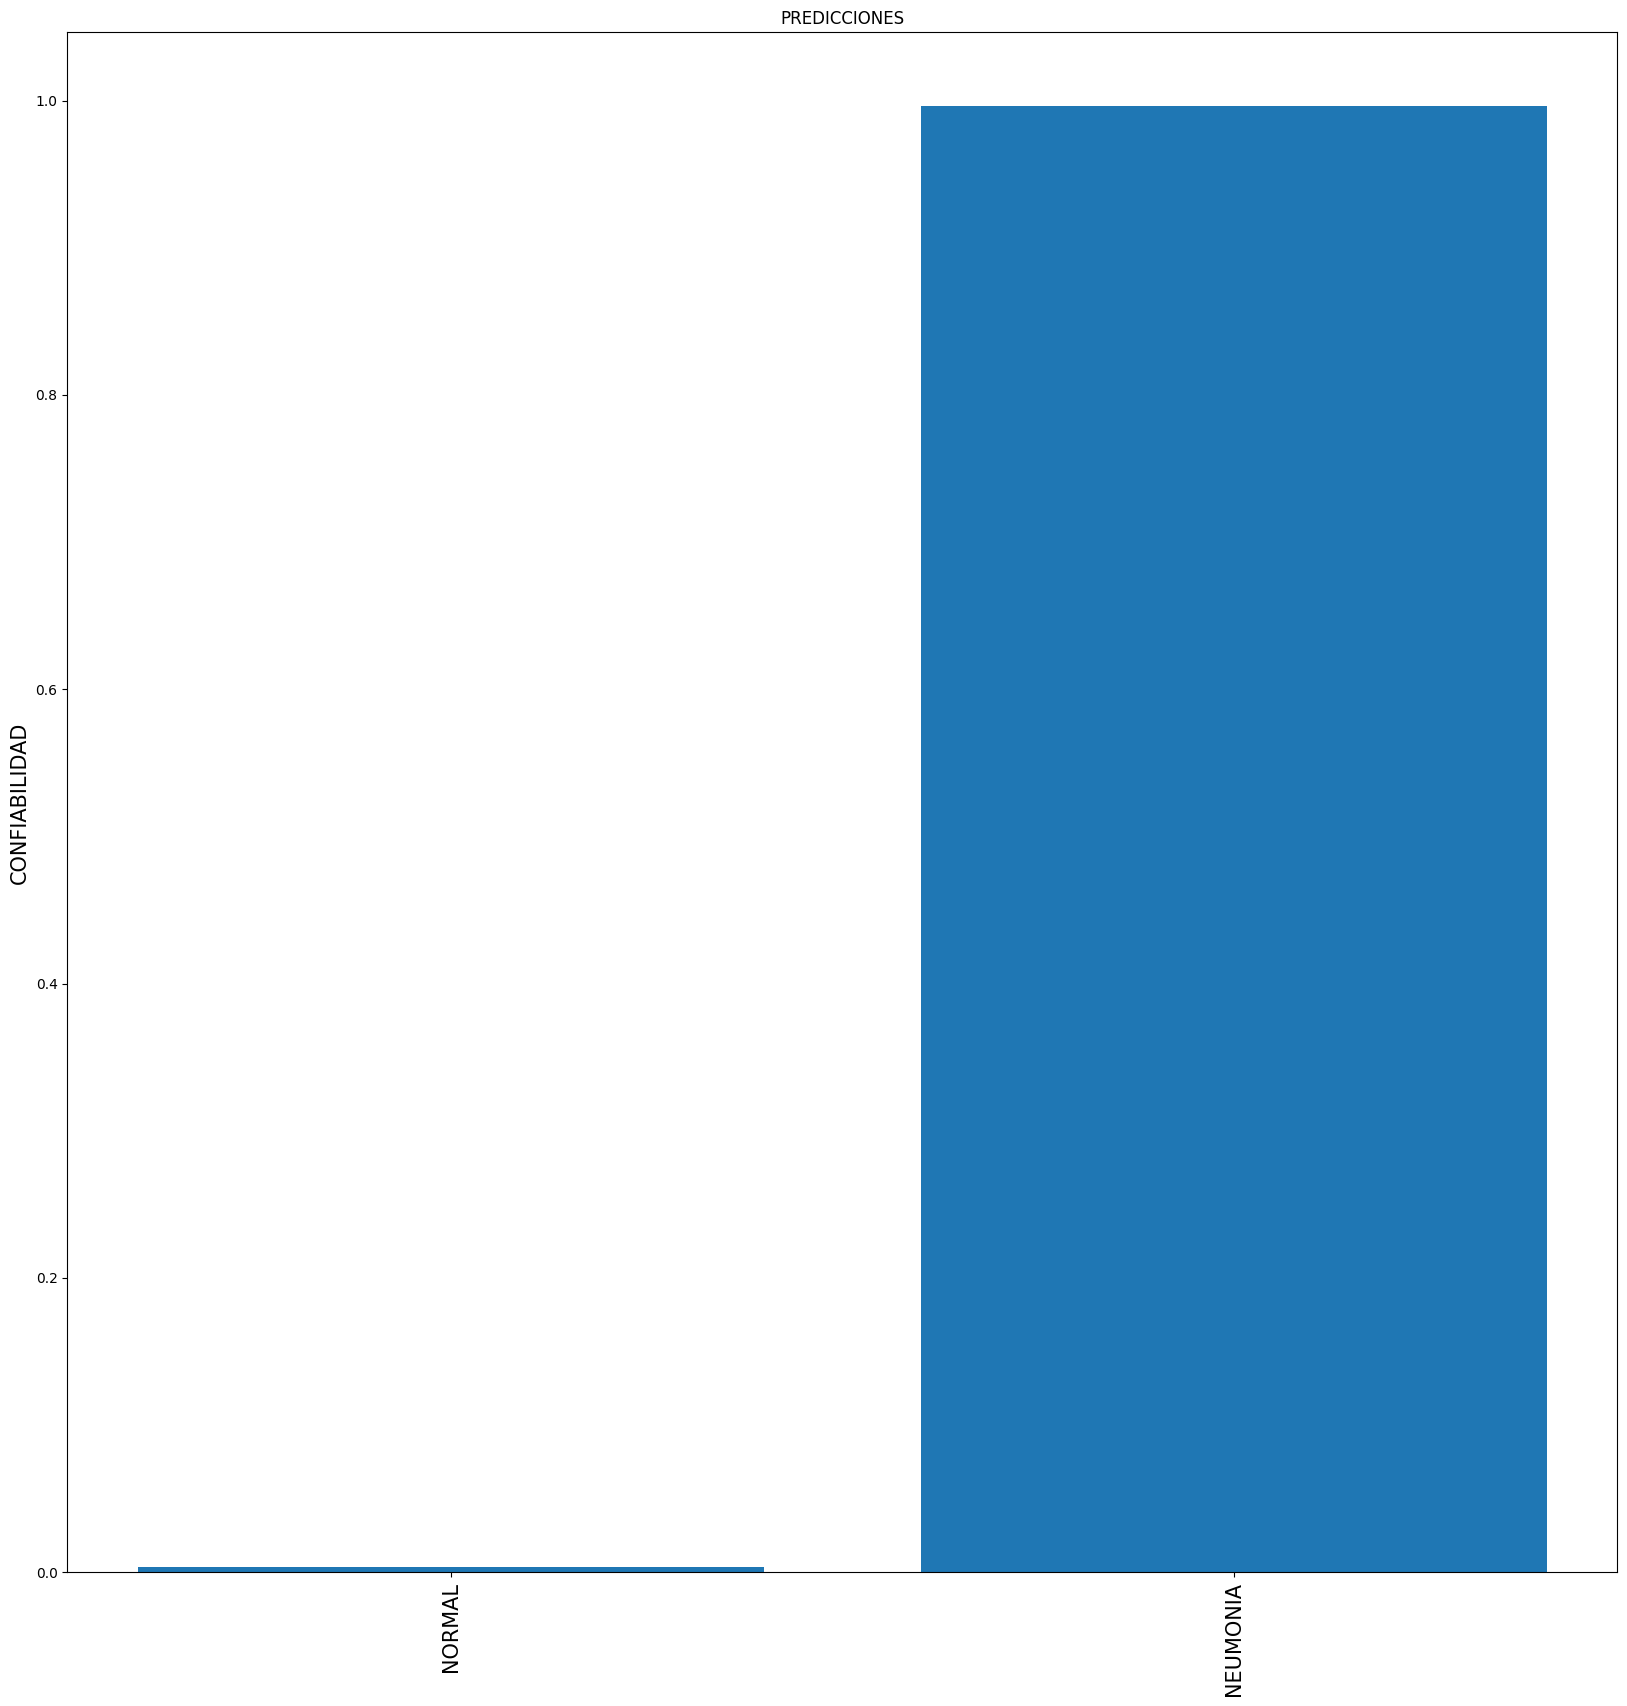

In [141]:
class_names=['NORMAL','NEUMONIA']
index=np.arange(len(class_names))
plt.bar(index,predictions[109])
plt.ylabel("CONFIABILIDAD",fontsize=15)
plt.xticks(index,class_names,fontsize=15,rotation=90)
plt.title("PREDICCIONES")
plt.show()

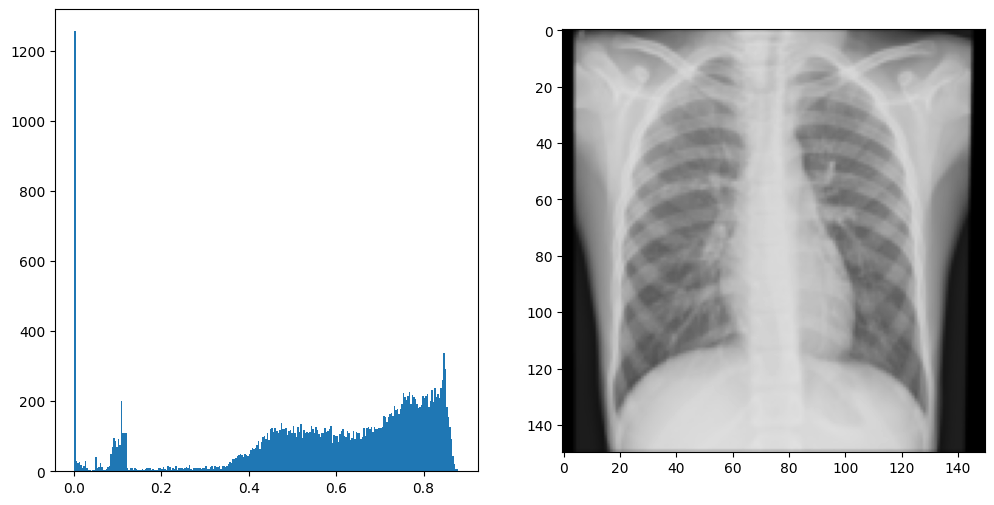

In [142]:
plotHistogram(x_test[109])

# REALIZA PREDICCIONES PROPIAS

In [143]:
def preprocess_image(file_path):
    # Cargar la imagen desde el archivo
    img_file = cv2.imread(file_path)
    # Verificar si la carga fue exitosa
    if img_file is not None:
        # Redimensionar la imagen a (150, 150, 3)
        img_file = skimage.transform.resize(img_file, (150, 150, 3), mode="constant", anti_aliasing=True)
        # Convertir a escala de grises
        img_file = rgb2gray(img_file)
        # Convertir a un array numpy
        img_arr = np.array(img_file)
        return img_arr
    else:
        print(f"No se pudo cargar la imagen desde el archivo: {file_path}")
        return None

In [183]:

# Ejemplo de uso
image_path = "ejemplo_imagenes/ejemploNeu.jpg"  # Reemplaza con la ruta de tu imagen
preprocessed_image = preprocess_image(image_path)
if preprocessed_image is not None:
    print("Procesamiento exitoso. Dimensiones de la imagen preprocesada:", preprocessed_image.shape)
else:
    print("Error durante el procesamiento de la imagen.")

Procesamiento exitoso. Dimensiones de la imagen preprocesada: (150, 150)


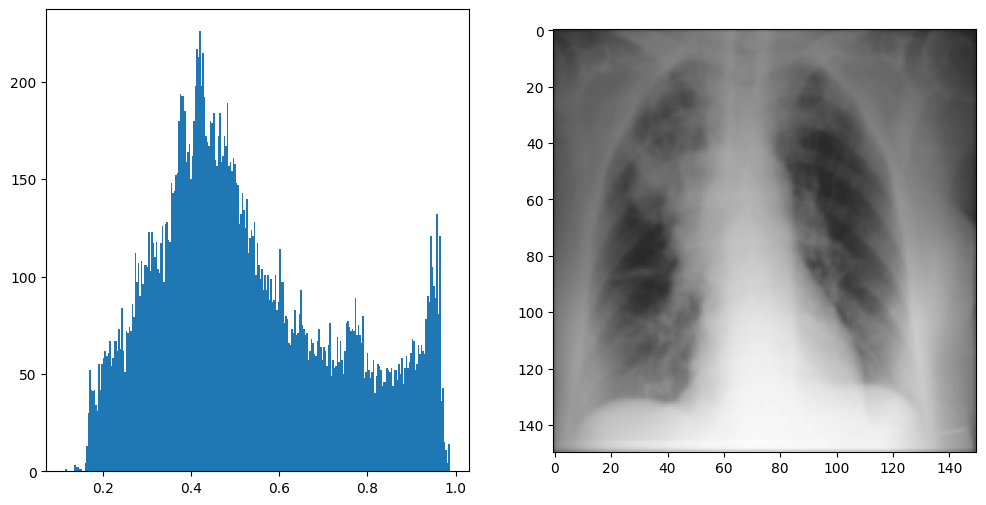

In [184]:
plotHistogram(preprocessed_image)

In [185]:
ejemplo_reshaped=preprocessed_image.reshape(1,150,150,1)
ejemplo_reshaped

array([[[[0.14260916],
         [0.17452336],
         [0.17993524],
         ...,
         [0.13627105],
         [0.13574474],
         [0.11478164]],

        [[0.1671852 ],
         [0.20393816],
         [0.21644143],
         ...,
         [0.16293266],
         [0.15978863],
         [0.13718061]],

        [[0.167458  ],
         [0.19986214],
         [0.20733162],
         ...,
         [0.17188417],
         [0.16351529],
         [0.14069108]],

        ...,

        [[0.46811035],
         [0.5564941 ],
         [0.58112927],
         ...,
         [0.55255371],
         [0.51611365],
         [0.37642762]],

        [[0.45059271],
         [0.53551601],
         [0.55876189],
         ...,
         [0.5497892 ],
         [0.51559416],
         [0.38050435]],

        [[0.38902009],
         [0.46455912],
         [0.4829283 ],
         ...,
         [0.47796695],
         [0.44887499],
         [0.33853259]]]])

In [186]:
my_prediccion_ejemplo = model.predict(ejemplo_reshaped)
my_prediccion_ejemplo[0]

1/1 [==============================] - 0s 48ms/step


array([0.03379078, 0.9662092 ], dtype=float32)

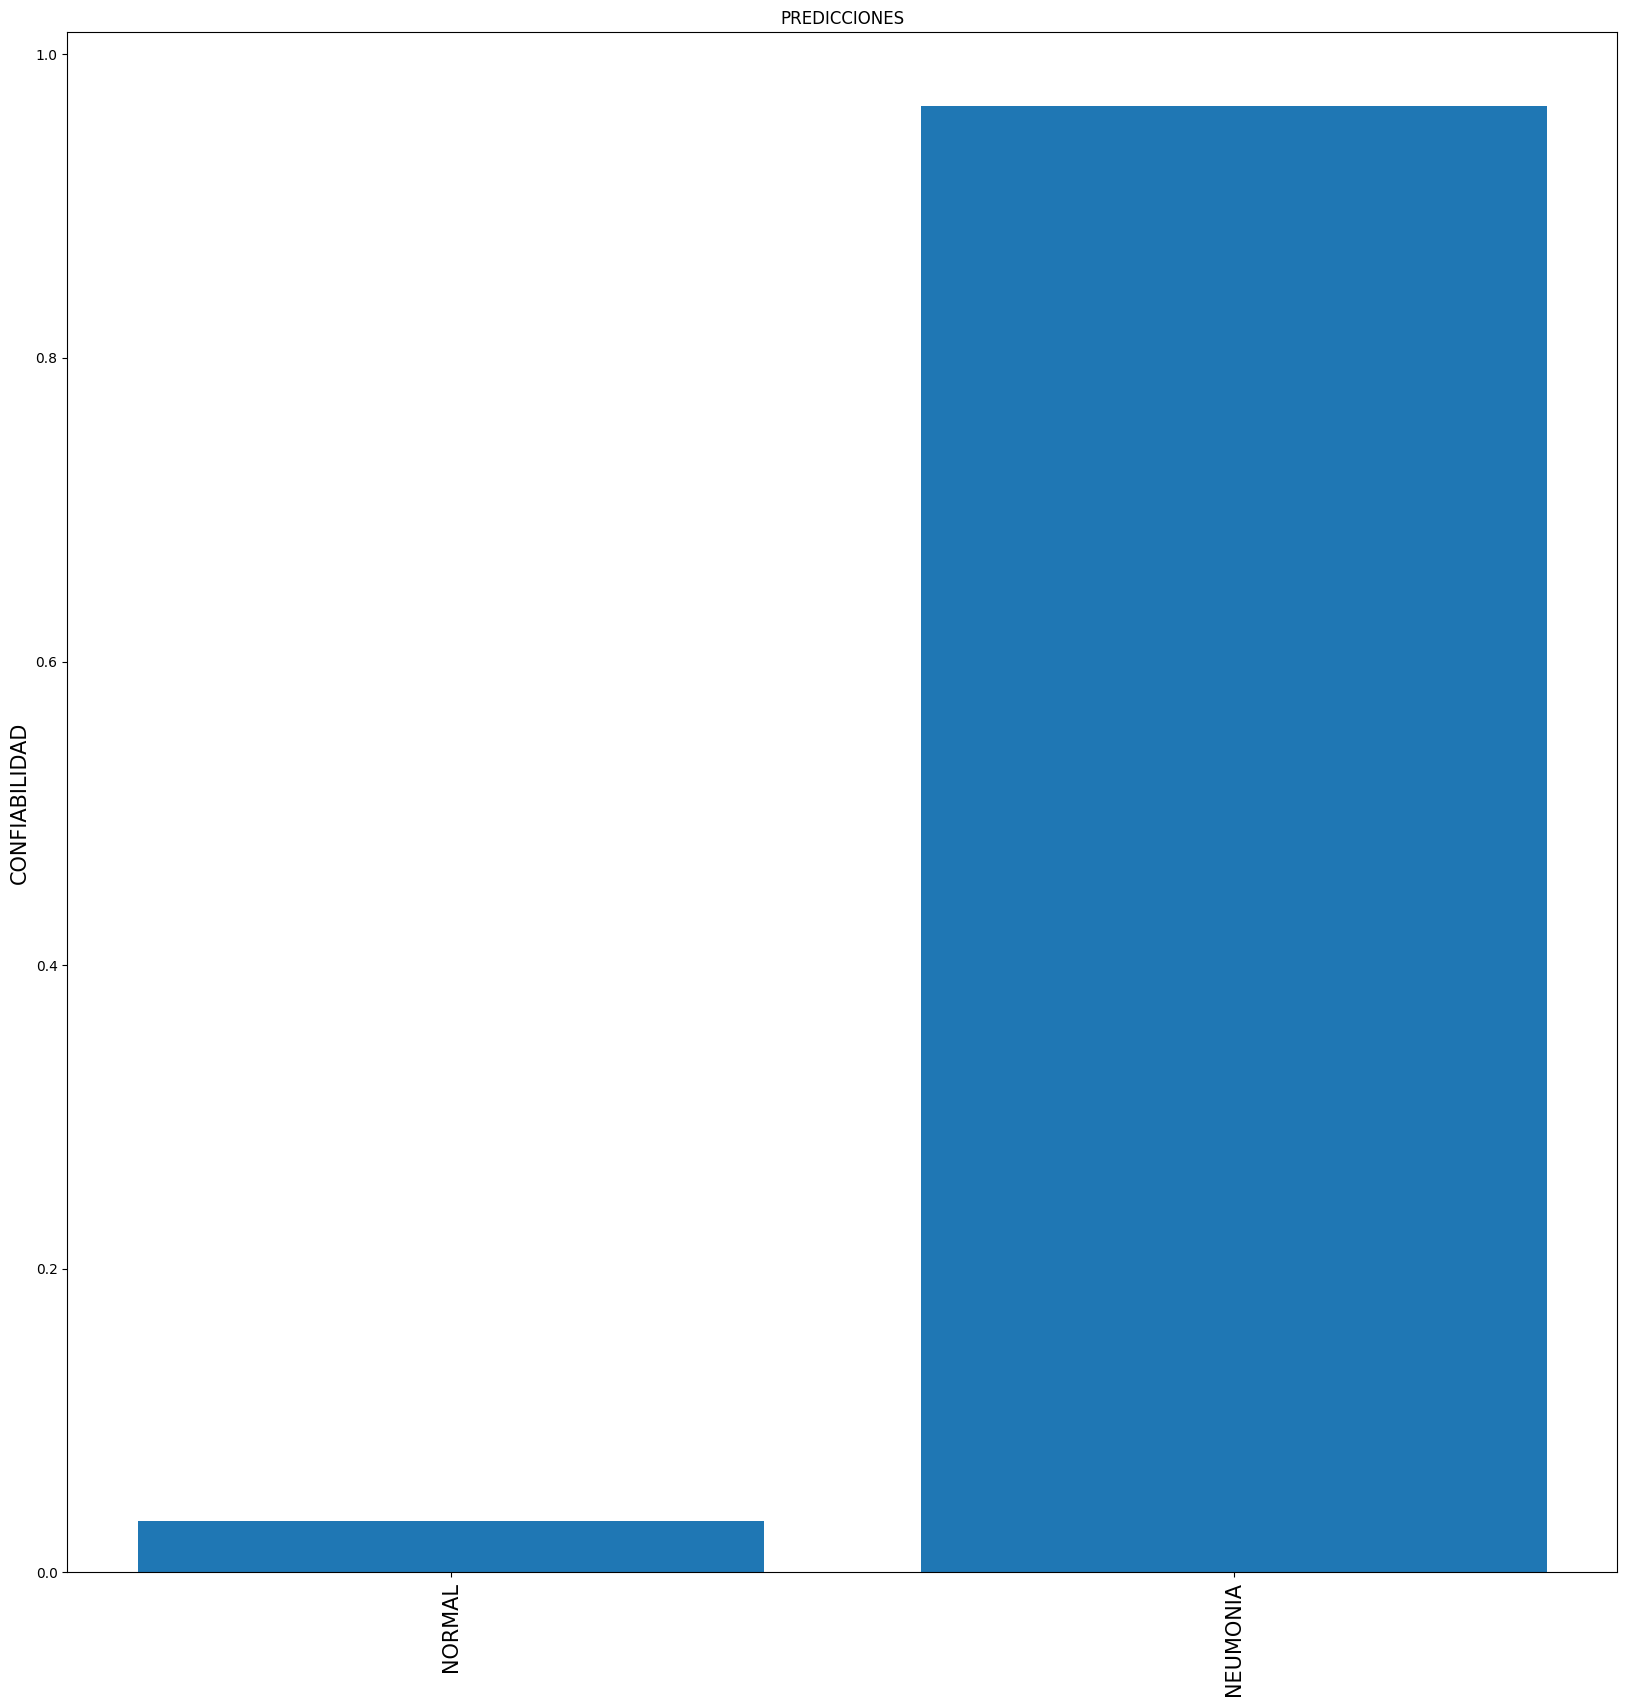

In [187]:
class_names=['NORMAL','NEUMONIA']
index=np.arange(len(class_names))
plt.bar(index,my_prediccion_ejemplo[0])
plt.ylabel("CONFIABILIDAD",fontsize=15)
plt.xticks(index,class_names,fontsize=15,rotation=90)
plt.title("PREDICCIONES")
plt.show()